Examine the distribution of noise in production data.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import robust_kurtosis, robust_skewness
from scipy.stats import kstest, norm, laplace, logistic, gennorm

import warnings
warnings.filterwarnings('ignore')

golden_ratio = (1 + np.sqrt(5)) / 2

In [3]:
# create function to calculate modified ARPS decline
def calc_modified_arps(qi=None, di=None, b=None, dmin=None, qab=None):
        """
        Calculate a modified ARPS decline with a terminal exponential 
        decline and an abandonment rate.
        
        Parameters:
        - qi: Initial production rate, bopd
        - di: Initial decline rate, effecitve annual
        - b: b-factor
        - dmin: Minimum decline rate, effective annual
        - r_abandon: Abandonment rate, bopd
        
        Returns:
        - Production rate at time t
        """
        t = np.arange(0, 365 * 100)
        D_tangent = ((1 - di) ** (-b) - 1) / b
        D_terminal = -1 * np.log(1 - dmin)
        q_terminal = qi * (D_terminal / D_tangent) ** (1 / b)
        t_terminal = ((qi / q_terminal) ** b - 1) / (b * D_tangent / 365)

        x = np.zeros(len(t))
        mask = t < t_terminal
        x[mask] = qi * (1 + b * (D_tangent / 365) * t[mask]) ** (-1 / b)
        x[~mask] = q_terminal * np.exp(-1 * (D_terminal / 365) * (t[~mask] - t_terminal))
        x[x < qab] = 0

        return x

def calculate_variogram_for_ts(ts, n_lags=10):
        """
        Calculate the variogram for a time series.

        Parameters:
        - ts: Time series
        - n_lags: Number of lags to calculate the variogram for

        Returns:
        Vector of the semi-variance for each lag
        """
        variances = np.zeros(n_lags)
        for i in range(n_lags):
                variances[i] = 0.5 * np.mean((ts[(i+1):] - ts[:-(i+1)]) ** 2)
        return variances

In [57]:
# load the data into a df
prod = pd.read_csv(r'DAILY_PRODUCTION.csv')
prod['D_DATE'] = pd.to_datetime(prod['D_DATE'])
prod['ON'] = np.where(prod['OIL'] > 1, 1, 0)
prod['DAYS_ON'] = prod.groupby('WELL_NAME')['ON'].cumsum()
prod = prod[prod['ON'] > 0].copy()
prod['PCT_CHANGE'] = (prod['OIL'] - prod['OIL'].shift(1)) / prod['OIL'].shift(1) * 100
prod['REL_CHANGE'] = (prod['OIL'] - prod['OIL'].shift(1)) / prod['OIL']   
prod['REL_CHANGE_MOVING_AVG'] = prod['REL_CHANGE'].rolling(window=30, center=True).mean()
prod['PCT_CHANGE_MOVING_AVG'] = prod['PCT_CHANGE'].rolling(window=30, center=True).mean()

# filter any extreme values that will skew analytic plots further below
prod = prod[prod['PCT_CHANGE'] < 100000].copy()

In [58]:
prod.head()

,PROPNUM,WELL_NAME,D_DATE,OIL,GAS,GAS_SALES,WATER,ON,DAYS_ON,PCT_CHANGE,REL_CHANGE,REL_CHANGE_MOVING_AVG,PCT_CHANGE_MOVING_AVG
2,N7RDMTXMLL,BUXBAUM 21-5-3H,2015-02-13,987.63,660.00,NaN,2511.00,1,2,-32.733291,-0.486619,NaN,NaN
3,N7RDMTXMLL,BUXBAUM 21-5-3H,2015-02-14,1045.85,608.61,NaN,2161.69,1,3,5.894920,0.055668,NaN,NaN
4,N7RDMTXMLL,BUXBAUM 21-5-3H,2015-02-15,1011.69,615.61,NaN,1841.76,1,4,-3.266243,-0.033765,NaN,NaN
5,N7RDMTXMLL,BUXBAUM 21-5-3H,2015-02-16,941.97,568.86,NaN,1608.48,1,5,-6.891439,-0.074015,NaN,NaN
6,N7RDMTXMLL,BUXBAUM 21-5-3H,2015-02-17,903.01,533.00,NaN,1352.43,1,6,-4.136013,-0.043145,NaN,NaN


In [59]:
prod.describe().T

,count,mean,min,25%,50%,75%,max,std
D_DATE,7571,2019-11-05 07:17:16.111478016,2015-02-13 00:00:00,2018-01-30 00:00:00,2019-11-11 00:00:00,2021-09-30 12:00:00,2024-01-23 00:00:00,NaN
OIL,7571.0,138.12884,1.03,26.9,52.56,130.43,1610.5,209.683567
GAS,7571.0,195.766805,-8.75,70.5,109.4,223.0,3119.0,223.476981
GAS_SALES,4874.0,297.77698,0.0,84.9225,125.79,474.0,112224.34,1631.020968
WATER,7571.0,206.317637,-129.4,48.04,88.28,206.19,3180.51,305.101966
ON,7571.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
DAYS_ON,7571.0,1330.700964,1.0,632.0,1263.0,1980.0,3100.0,827.014199
PCT_CHANGE,7571.0,17.915952,-99.363636,-12.01377,0.0,12.676011,18978.723404,274.247949
REL_CHANGE,7571.0,-0.16399,-156.142857,-0.136541,0.0,0.1125,0.994759,2.194005
REL_CHANGE_MOVING_AVG,7542.0,-0.162591,-5.896151,-0.14751,-0.046992,-0.017032,0.050904,0.404841


# INVESTIGATE DAILY RATE

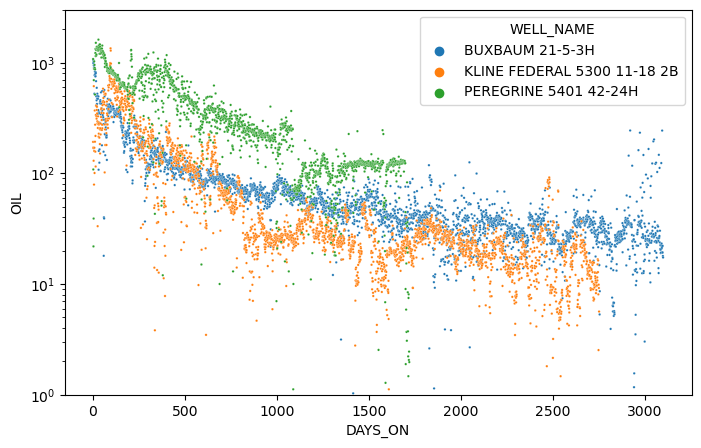

In [60]:
# plot the rate-time profile for each well
fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5))
sns.scatterplot(x='DAYS_ON', y='OIL', hue='WELL_NAME', data=prod, ax=ax, s=3)
ax.set(yscale='log', ylim=(1,3000))
plt.show()

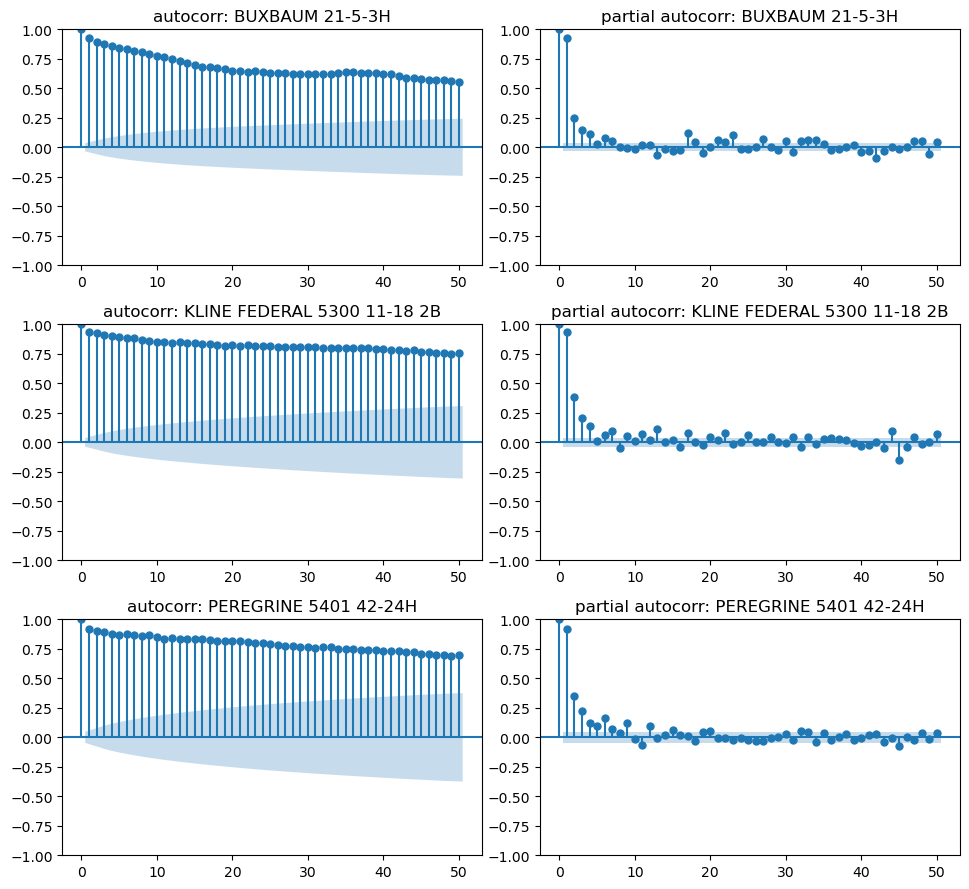

In [61]:
# plot the autcorr and partial autocorr for each well
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(2 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    ax = axs[i, 0]
    plot_acf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].dropna(), ax=ax, lags=50)
    ax.set(title='autocorr: ' + well)
    ax = axs[i, 1]
    plot_pacf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].dropna(), ax=ax, lags=50)
    ax.set(title='partial autocorr: ' + well)
plt.tight_layout(); plt.show()

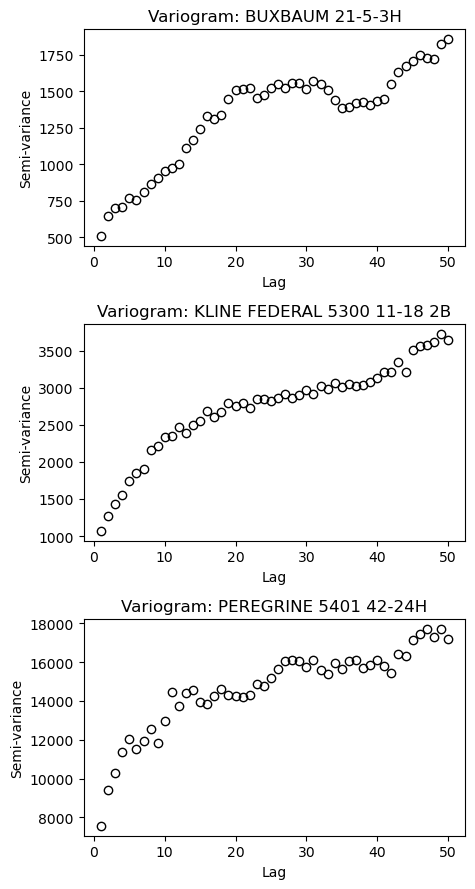

In [62]:
# plot variogram for each well
lags=50
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    variances = calculate_variogram_for_ts(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].dropna().values, 
                                           n_lags=lags)
    axs[i].plot(range(1, lags + 1), variances, 'o', mfc='none', mec='k')
    axs[i].set(title='Variogram: ' + well, xlabel='Lag', ylabel='Semi-variance')
plt.tight_layout(); plt.show()

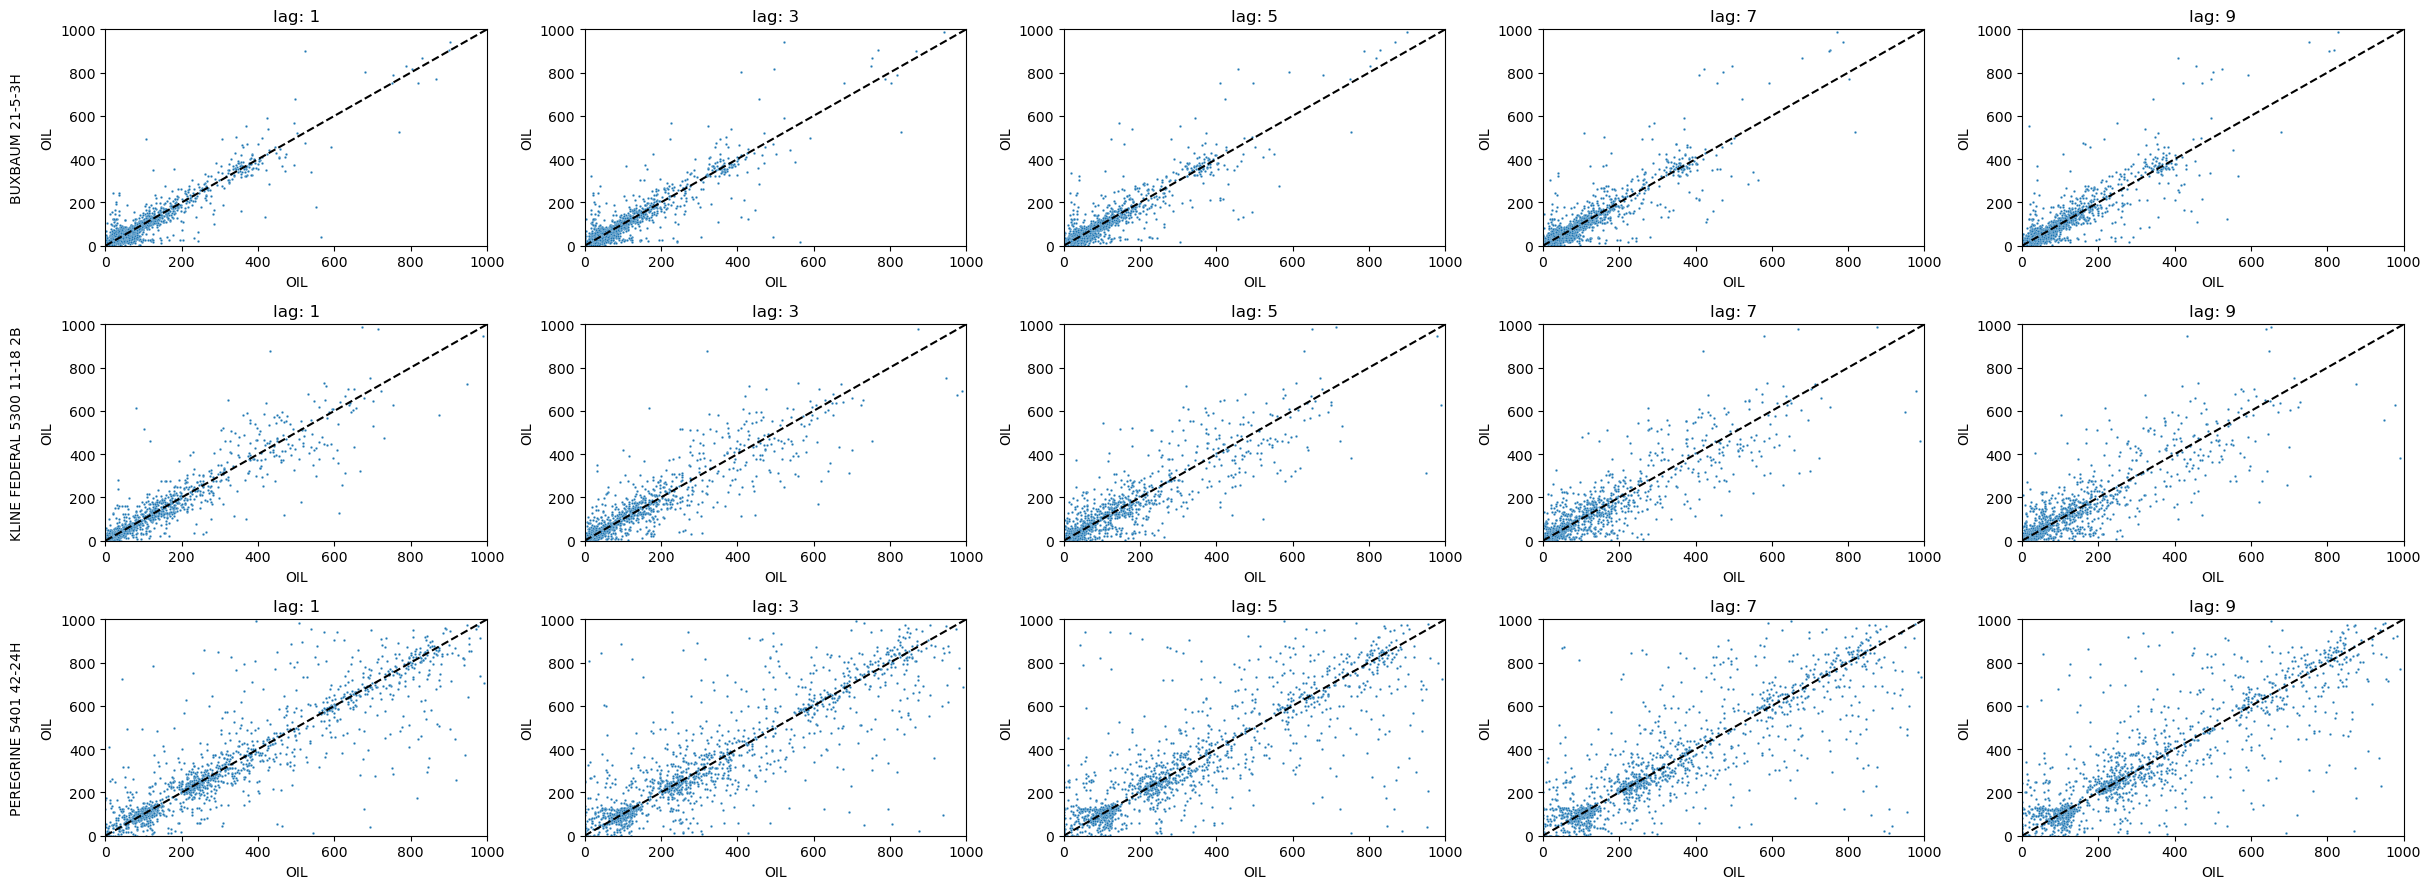

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(5 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    for j, lag in enumerate(range(1,10,2)):
        ax = axs[i, j]
        data = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL']
        shifted_data = data.shift(lag)
        sns.scatterplot(x=data, y=shifted_data, ax=ax, s=3)
        ax.plot([0, 1000], [0, 1000], color='black', linestyle='--')
        ax.set(xlim=(0,1000), ylim=(0,1000), title='lag: ' + str(lag))
        
    # Add well name as a label on the left side and rotate 180 degrees
    axs[i, 0].text(-0.25, 0.5, well, transform=axs[i, 0].transAxes, va='center', rotation=90)
    
plt.tight_layout(); plt.show()


There is autocorrelation in daily production data up to the 4th lag.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3099
Model:                 ARIMA(4, 0, 1)   Log Likelihood              -14700.578
Date:                Sat, 03 Feb 2024   AIC                          29415.157
Time:                        16:59:41   BIC                          29457.428
Sample:                             0   HQIC                         29430.337
                               - 3099                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2485      0.226     -1.101      0.271      -0.691       0.194
ar.L1          1.0626      0.016     65.996      0.000       1.031       1.094
ar.L2         -0.1540      0.013    -11.600      0.0

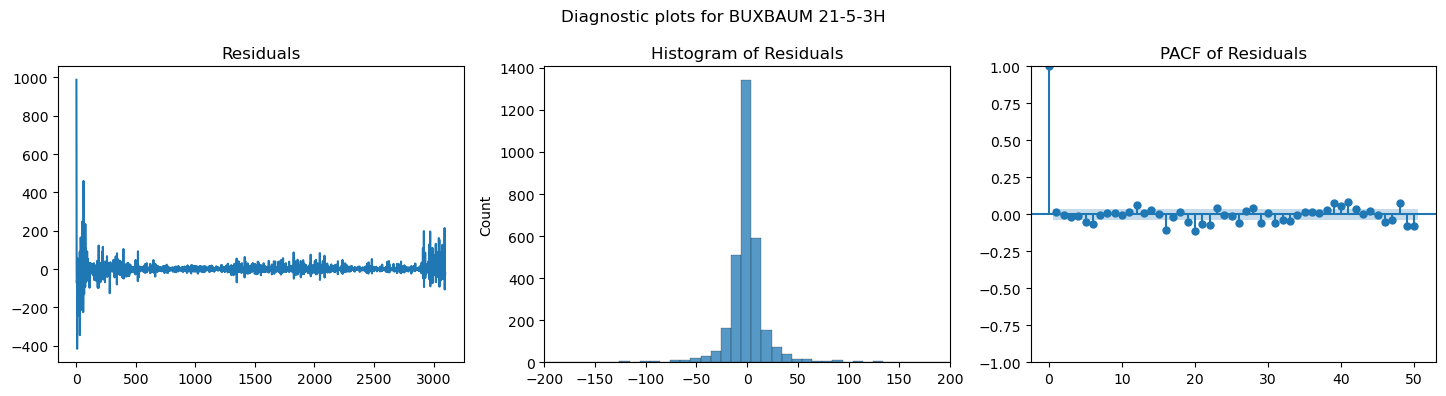

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2752
Model:                 ARIMA(4, 0, 1)   Log Likelihood              -14077.447
Date:                Sat, 03 Feb 2024   AIC                          28168.894
Time:                        16:59:42   BIC                          28210.334
Sample:                             0   HQIC                         28183.865
                               - 2752                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0051      0.181      0.028      0.978      -0.349       0.359
ar.L1          1.3736      0.007    187.281      0.000       1.359       1.388
ar.L2         -0.1951      0.009    -20.768      0.0

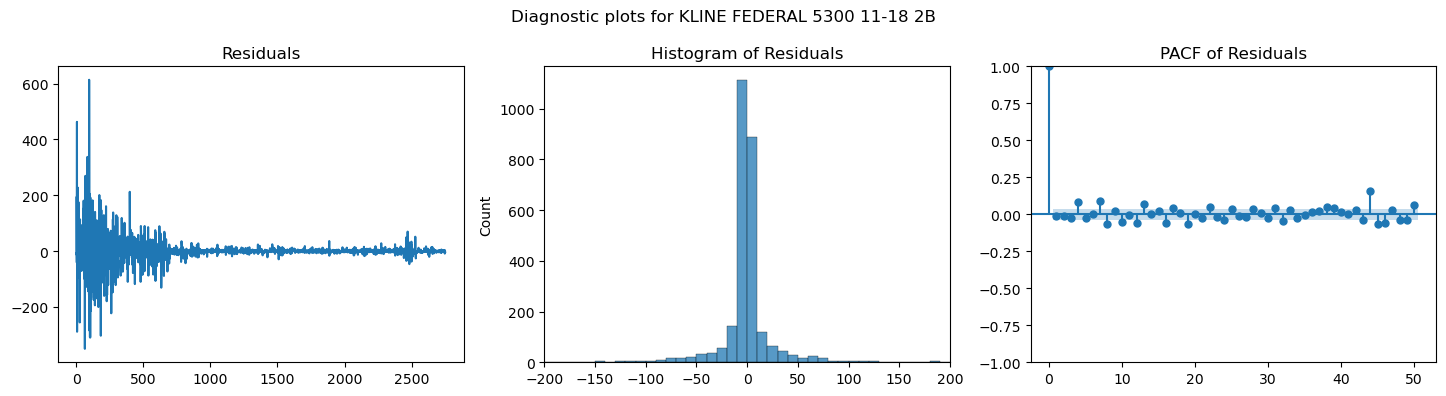

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1720
Model:                 ARIMA(4, 0, 1)   Log Likelihood              -10471.957
Date:                Sat, 03 Feb 2024   AIC                          20957.914
Time:                        16:59:43   BIC                          20996.064
Sample:                             0   HQIC                         20972.029
                               - 1720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2340      0.440     -0.531      0.595      -1.097       0.629
ar.L1          1.3492      0.015     90.700      0.000       1.320       1.378
ar.L2         -0.2621      0.019    -13.830      0.0

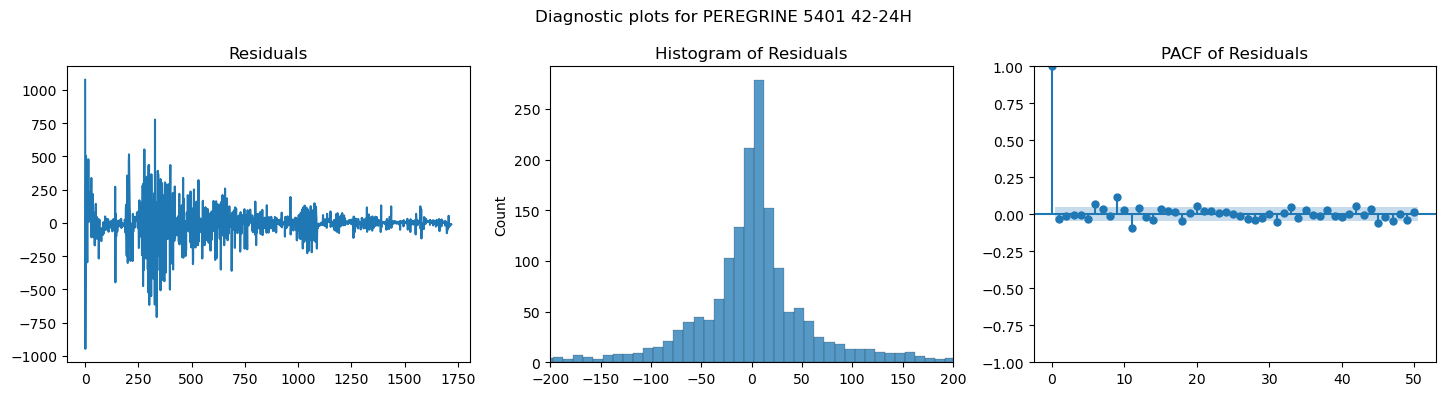

In [63]:

arima_models = {}
for well in prod['WELL_NAME'].unique():
    # build ARIMA model
    arima_models[well] = ARIMA(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].values, 
                               order=(4, 0, 1), trend='t').fit()
    print(arima_models[well].summary())
    
    # Plot diagnostic
    fig, axs = plt.subplots(ncols=3,figsize=(3 * 3 * golden_ratio, 4))
    axs[0].plot(arima_models[well].resid)
    axs[0].set_title('Residuals')
    sns.histplot(np.clip(arima_models[well].resid, -1000, 1000), ax=axs[1], binwidth=10)
    axs[1].set(title='Histogram of Residuals', xlim=(-200, 200))
    plot_pacf(arima_models[well].resid, lags=50, ax=axs[2])
    axs[2].set_title('PACF of Residuals')
    fig.suptitle('Diagnostic plots for ' + well)
    plt.tight_layout(), plt.show()

In [64]:
# create a table of the skew and kurtois for each well
resid_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'MEAN', 'MEDIAN', 'STD', 'SKEW', 'KURT'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    mean = np.mean(arima_models[well].resid)
    median = np.median(arima_models[well].resid)
    std = np.std(arima_models[well].resid)
    skew = robust_skewness(arima_models[well].resid)[1]
    kurt = robust_kurtosis(arima_models[well].resid)[1]
    resid_dist.loc[i] = [well, mean, median, std, skew, kurt]
resid_dist.head(5)



,WELL_NAME,MEAN,MEDIAN,STD,SKEW,KURT
0,BUXBAUM 21-5-3H,0.244539,0.194832,32.948995,-0.128103,0.538659
1,KLINE FEDERAL 5300 11-18 2B,0.300482,-0.454134,40.480008,0.055342,1.311641
2,PEREGRINE 5401 42-24H,0.761194,3.381610,110.287174,-0.123539,1.045957


- mean and median ~ 0
- Residual STD ranges from 40 - 111
- Skew is ~ 0
- Kurtosis is ~ 1

An ARIMA(1,0,1) model adequatly describes the TS. With the exception of the Kline, the resulting residuals are 
stationary.

The residuals are visually not normally distributed. JB tests confirm this. Kurtosis is ~ 1.
To approximate a kurtosis ~ 1, test if a laplace function matches the distribution of residuals.

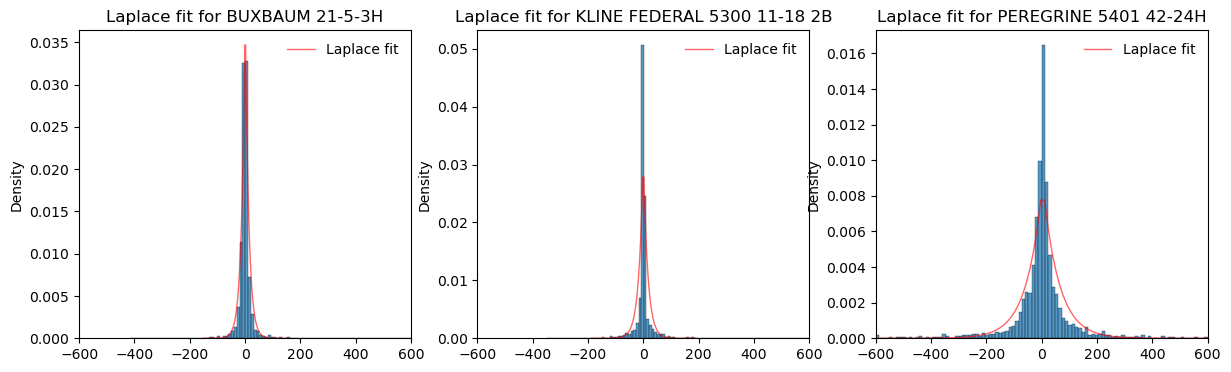

,WELL_NAME,LOC,SCALE,LOG_LIKELIHOOD,KS_STAT,KS_STAT_PVAL
0,BUXBAUM 21-5-3H,0.194832,12.807106,-13149.513581,0.086370,1.458975e-20
1,KLINE FEDERAL 5300 11-18 2B,-0.454134,15.946611,-12280.506987,0.158238,1.174239e-60
2,PEREGRINE 5401 42-24H,3.381610,57.240578,-9873.505587,0.098868,4.353874e-15


In [65]:
# test goodness of fit of a laplace error distribution
distribution = laplace

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
laplace_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'LOC', 'SCALE', 'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(arima_models[well].resid, -600, 600)
    fit = distribution.fit(data)
    loc, scale = fit[0], fit[1]
    log_likelihood = distribution.logpdf(data, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'laplace', args=(loc, scale))
    laplace_dist.loc[i] = [well, loc, scale, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', bins=100)
    x = np.linspace(distribution.ppf(0.01, loc, scale * 3), distribution.ppf(0.99, loc, scale * 3), 100)
    axs[i].plot(x, distribution.pdf(x, loc, scale), 'r-', lw=1, alpha=0.6, label='Laplace fit')
    axs[i].set(title='Laplace fit for ' + well, xlim=(-600,600))
    axs[i].legend(loc='best', frameon=False)
plt.show()
laplace_dist.head(5)


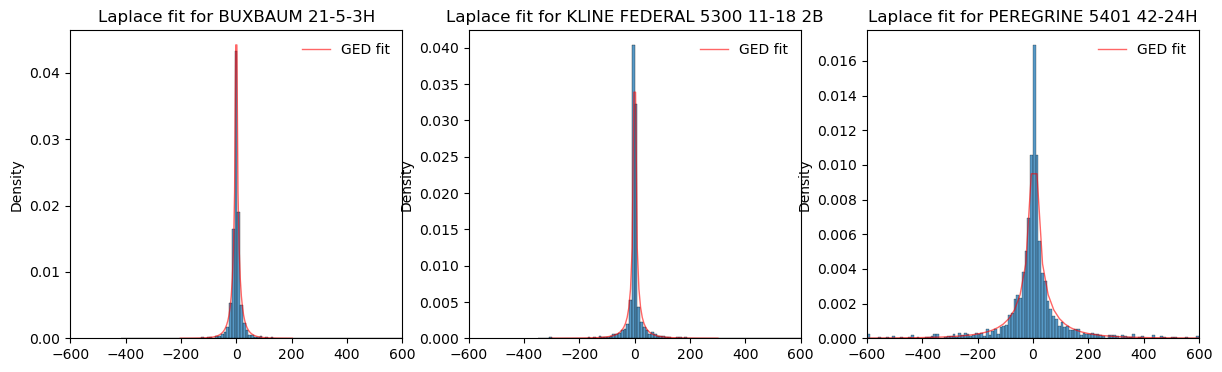

,WELL_NAME,BETA,LOC,SCALE,LOG_LIKELIHOOD,KS_STAT,KS_STAT_PVAL
0,BUXBAUM 21-5-3H,0.531069,0.194873,2.611075,-12780.293545,0.031706,3.850668e-03
1,KLINE FEDERAL 5300 11-18 2B,0.353855,0.537543,0.373631,-11316.067740,0.105995,2.235622e-27
2,PEREGRINE 5401 42-24H,0.467981,4.501457,7.092975,-9653.322909,0.037357,1.602885e-02


In [66]:
# test goodness of fit of a gennorm error distribution
distribution = gennorm

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
gennorm_dist = pd.DataFrame(np.zeros([3,7]), columns=['WELL_NAME', 'BETA', 'LOC', 'SCALE', 'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(arima_models[well].resid, -600, 600)
    fit = distribution.fit(data)
    beta, loc, scale = fit[0], fit[1], fit[2]
    log_likelihood = distribution.logpdf(data, beta=beta, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'gennorm', args=(beta, loc, scale))
    gennorm_dist.loc[i] = [well, beta, loc, scale, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', binwidth=10)
    x = np.linspace(distribution.ppf(0.01, beta, loc, scale * 3), distribution.ppf(0.99, beta, loc, scale * 3), 100)
    axs[i].plot(x, distribution.pdf(x, beta, loc, scale), 'r-', lw=1, alpha=0.6, label='GED fit')
    axs[i].set(title='Laplace fit for ' + well, xlim=(-600,600))
    axs[i].legend(loc='best', frameon=False)
plt.show()
gennorm_dist.head(5)

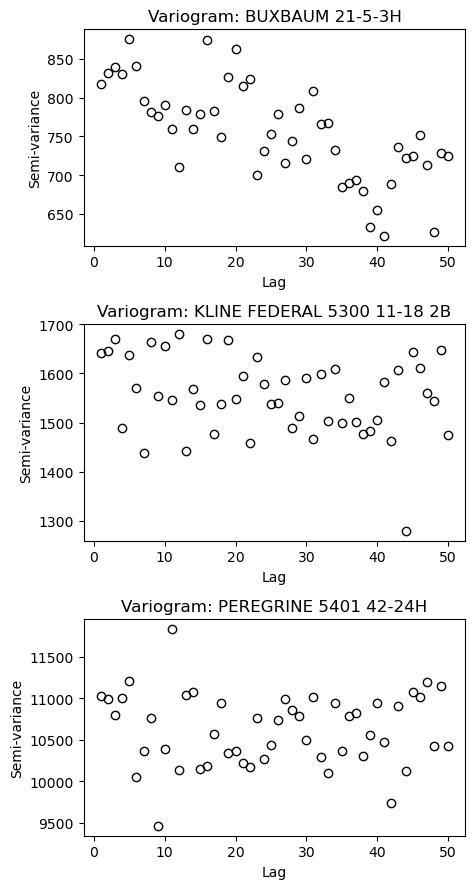

In [67]:
# plot variogram for each well
lags=50
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(arima_models[well].resid, -600, 600)
    variances = calculate_variogram_for_ts(data, 
                                           n_lags=lags)
    axs[i].plot(range(1, lags + 1), variances, 'o', mfc='none', mec='k')
    axs[i].set(title='Variogram: ' + well, xlabel='Lag', ylabel='Semi-variance')
plt.tight_layout(); plt.show()

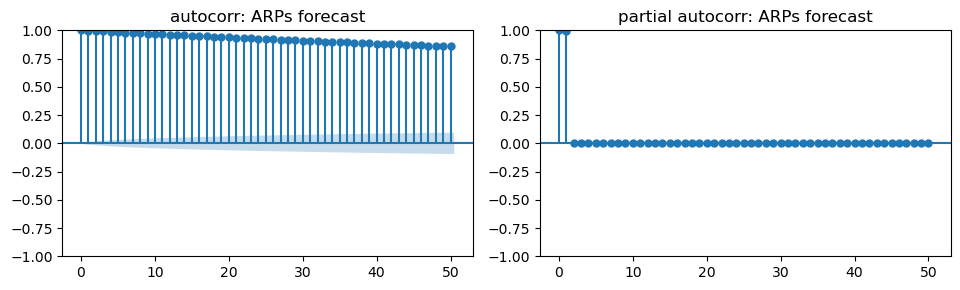

In [68]:
# build the model and view summaries
arps = calc_modified_arps(qi=3000, di=0.7, b=1.001, dmin=0.07, qab=1)

fig, axs = plt.subplots(ncols=2, figsize=(2 * 3 * golden_ratio, 3))
ax = axs[0]
plot_acf(arps, ax=ax, lags=50)
ax.set(title='autocorr: ARPs forecast')
ax = axs[1]
plot_pacf(arps, ax=ax, lags=50)
ax.set(title='partial autocorr: ARPs forecast')
plt.tight_layout(); plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                36500
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -39827.409
Date:                Sat, 03 Feb 2024   AIC                          79662.818
Time:                        17:00:21   BIC                          79696.839
Sample:                             0   HQIC                         79673.633
                              - 36500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        208.1795   1.26e-09   1.65e+11      0.000     208.179     208.179
x1            -0.0821      0.009     -8.761      0.000      -0.100      -0.064
ar.L1          1.0000   5.57e-07   1.79e+06      0.0

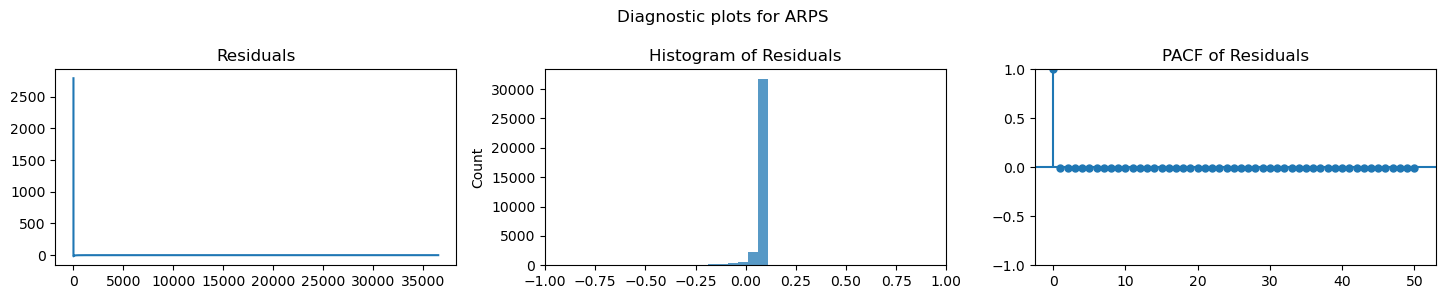

(None, None)

In [69]:
arima_models['ARPS'] = ARIMA(arps, order=(1, 0, 0), trend='ct').fit()  # AR(1) model
print(arima_models['ARPS'].summary())

fig, axs = plt.subplots(ncols=3,figsize=(3 * 3 * golden_ratio, 3))
axs[0].plot(arima_models['ARPS'].resid)
axs[0].set_title('Residuals')
sns.histplot(arima_models['ARPS'].resid, ax=axs[1], binwidth=0.05)
axs[1].set(title='Histogram of Residuals', xlim=(-1,1))
plot_pacf(arima_models['ARPS'].resid, lags=50, ax=axs[2])
axs[2].set_title('PACF of Residuals')
fig.suptitle('Diagnostic plots for ARPS')
plt.tight_layout(), plt.show()

# INVESTIGATE THE DAILY PERCENTAGE CHANGE

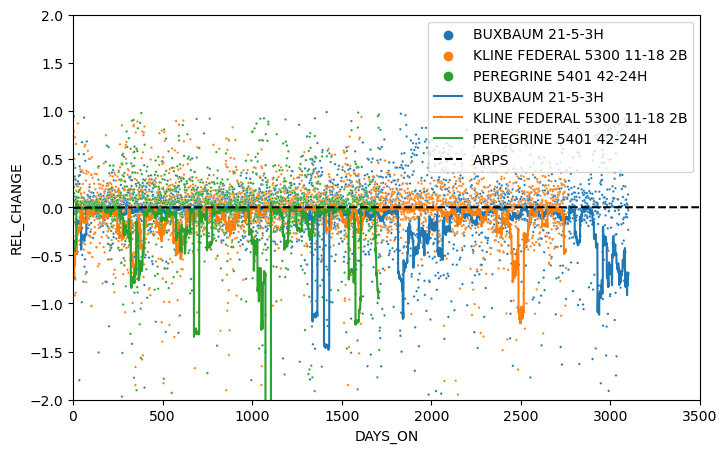

In [70]:
# plot the pct change profile for each well 
arps_pct_change = np.diff(arps) / arps[1:]

fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5))
sns.scatterplot(x='DAYS_ON', y='REL_CHANGE', hue='WELL_NAME', data=prod, ax=ax, s=3)
sns.lineplot(x='DAYS_ON', y='REL_CHANGE_MOVING_AVG', hue='WELL_NAME', data=prod, ax=ax)
ax.plot(range(0, len(arps_pct_change)), arps_pct_change, color='black', linestyle='--', label='ARPS')
ax.set(ylim=(-2,2), xlim=(0,3500))
ax.legend(loc='best', frameon=True)
plt.show()

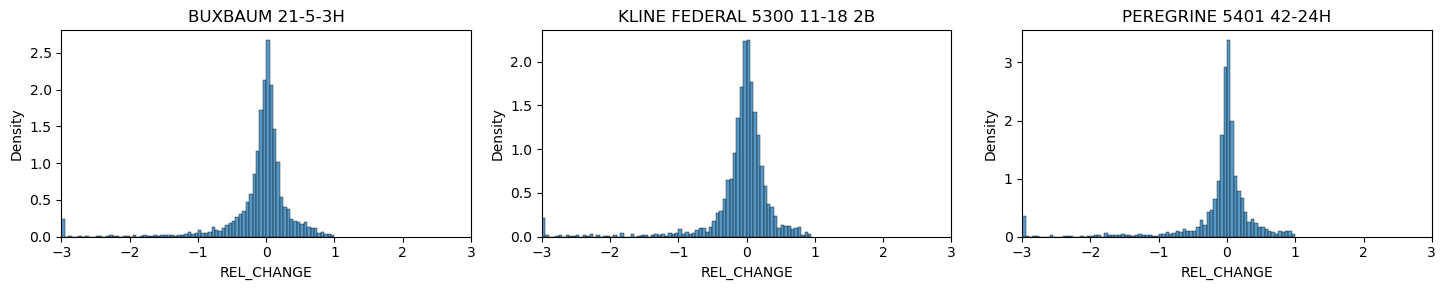

In [71]:
fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['REL_CHANGE'].dropna(), -3, 3)
    sns.histplot(data, ax=axs[i], stat='density', binwidth=0.05)
    axs[i].set(title=well, xlim=(-3,3))
plt.tight_layout(); plt.show()

In [72]:
# create a table of the skew and kurtois for each well
resid_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'MEAN', 'MEDIAN', 'STD', 'SKEW', 'KURT'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['REL_CHANGE'].dropna(), -300, 300)
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)
    skew = robust_skewness(data)[1]
    kurt = robust_kurtosis(data)[1]
    resid_dist.loc[i] = [well, mean, median, std, skew, kurt]
resid_dist.head(5)

,WELL_NAME,MEAN,MEDIAN,STD,SKEW,KURT
0,BUXBAUM 21-5-3H,-0.139000,0.001219,1.282648,-0.140024,0.689164
1,KLINE FEDERAL 5300 11-18 2B,-0.110560,-0.002090,0.872558,-0.054133,0.404660
2,PEREGRINE 5401 42-24H,-0.294505,0.001165,4.120751,-0.070846,1.195172


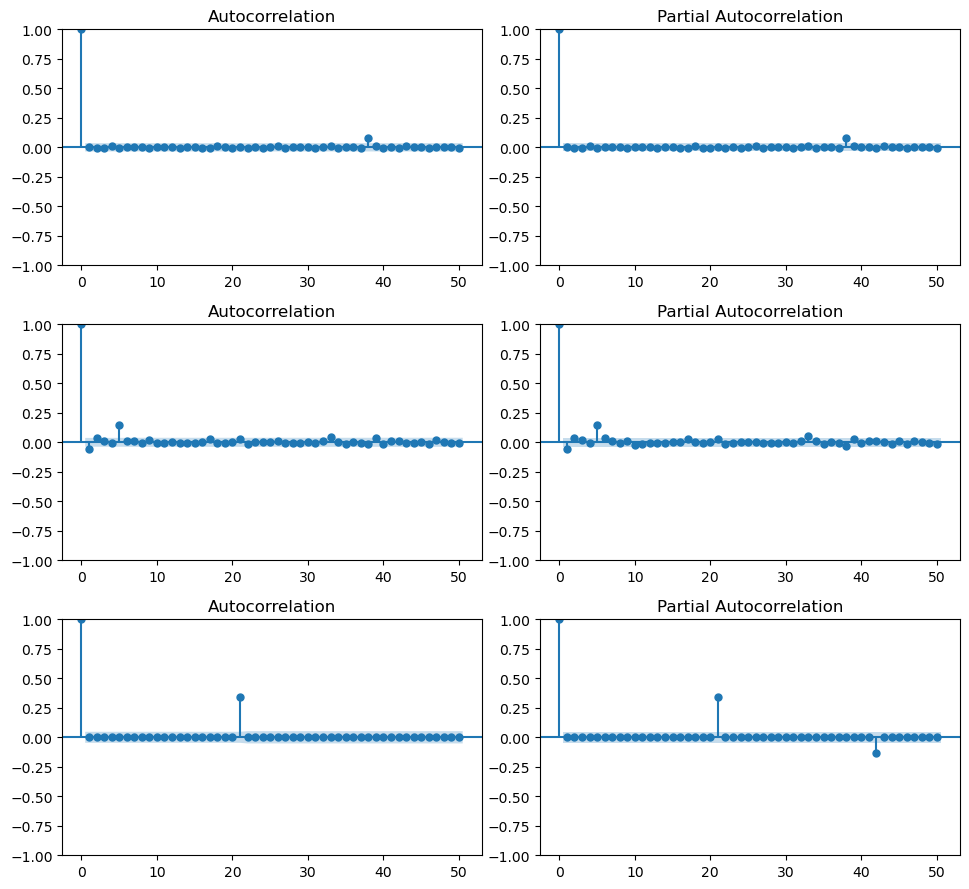

In [28]:
# plot the autcorr and partial autocorr for each well
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(2 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    plot_acf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['REL_CHANGE'].dropna(), ax=axs[i,0], lags=50)
    ax.set(title='autocorr: ' + well, xlabel='Lags')
    plot_pacf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['REL_CHANGE'].dropna(), ax=axs[i,1], lags=50)
    ax.set(title='partial autocorr: ' + well, xlabel='Lags')
plt.tight_layout(); plt.show()

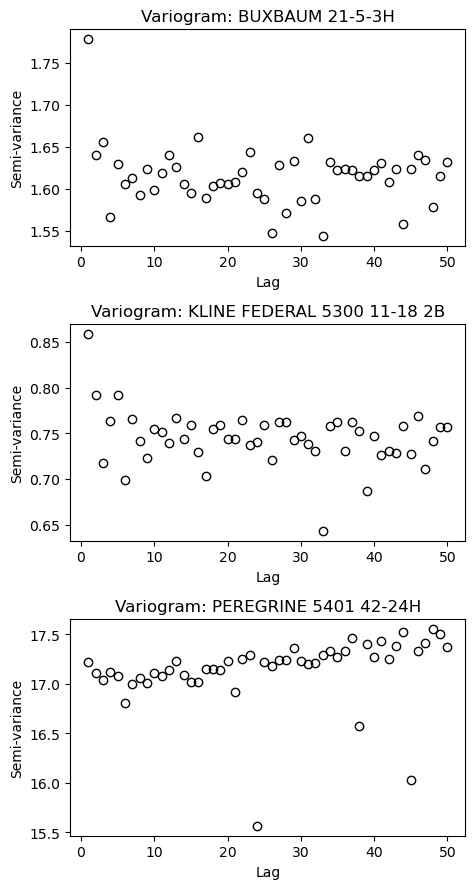

In [75]:
# plot variogram for each well
lags=50
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    variances = calculate_variogram_for_ts(prod.loc[(prod['WELL_NAME'] == well) & 
                                                    (prod['ON'])]['REL_CHANGE'].dropna().values, 
                                           n_lags=lags)
    axs[i].plot(range(1, lags + 1), variances, 'o', mfc='none', mec='k')
    axs[i].set(title='Variogram: ' + well, xlabel='Lag', ylabel='Semi-variance')
plt.tight_layout(); plt.show()

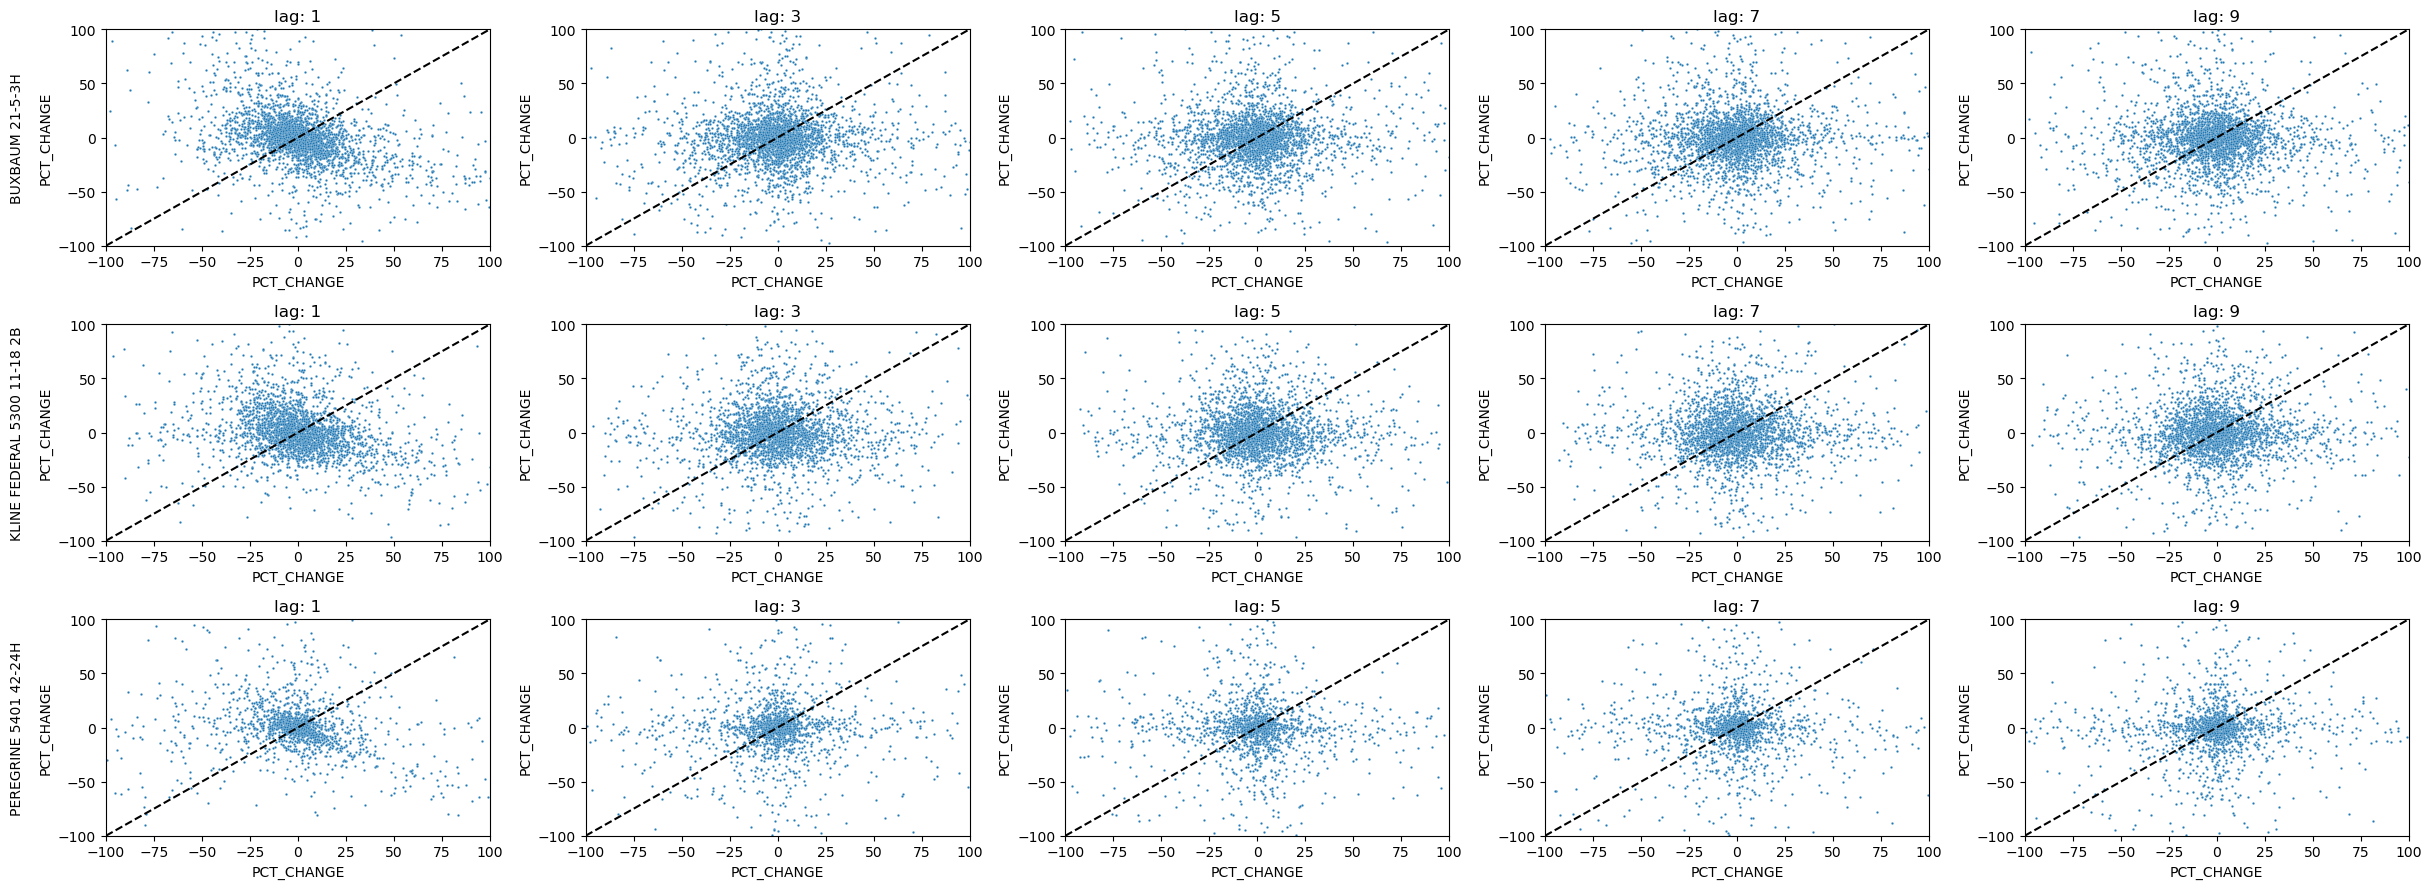

In [76]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(5 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    for j, lag in enumerate(range(1,10,2)):
        ax = axs[i, j]
        data = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE']
        shifted_data = data.shift(lag)
        sns.scatterplot(x=data, y=shifted_data, ax=ax, s=3)
        ax.plot([-100, 100], [-100, 100], color='black', linestyle='--')
        ax.set(xlim=(-100,100), ylim=(-100,100), title='lag: ' + str(lag))
        
    # Add well name as a label on the left side and rotate 180 degrees
    axs[i, 0].text(-0.25, 0.5, well, transform=axs[i, 0].transAxes, va='center', rotation=90)
    
plt.tight_layout(); plt.show()

The daily percentage change in production appears to have no autocorrelation

In [ ]:
# test goodness of fit of a laplace error distribution
distribution = laplace

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
laplace_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'LOC', 'SCALE', 'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna().values, -300, 300)
    fit = distribution.fit(data)
    loc, scale = fit[0], fit[1]
    log_likelihood = distribution.logpdf(data, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'laplace', args=(loc, scale))
    laplace_dist.loc[i] = [well, loc, scale, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', binwidth=1)
    x = np.linspace(distribution.ppf(0.01, loc, scale * 3), distribution.ppf(0.99, loc, scale * 3), 100)
    axs[i].plot(x, distribution.pdf(x, loc, scale), 'r-', lw=1, alpha=0.6, label='Laplace fit')
    axs[i].set(title='Laplace fit for ' + well, xlim=(-300,300))
    axs[i].legend(loc='best', frameon=False)
plt.show()
laplace_dist.head(5)

In [ ]:
# test goodness of fit of a gennorm error distribution
distribution = gennorm

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
laplace_dist = pd.DataFrame(np.zeros([3,10]), columns=['WELL_NAME', 'BETA', 'LOC', 'SCALE', 'MEAN', 'MEDIAN', 'STD', 
                                                      'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna().values, -300, 300)
    fit = distribution.fit(data)
    beta, loc, scale = fit[0], fit[1], fit[2]
    scale_std = scale * np.sqrt(120)
    mean = np.mean(data)
    median = np.median(data)
    std = np.sqrt(distribution.var(beta, loc, scale))
    log_likelihood = distribution.logpdf(data, beta=beta, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'gennorm', args=(beta, loc, scale))
    laplace_dist.loc[i] = [well, beta, loc, scale, mean, median, std, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', binwidth=10)
    x = np.linspace(distribution.ppf(0.001, beta, loc, scale), distribution.ppf(0.999, beta, loc, scale), 100)
    axs[i].plot(x, distribution.pdf(x, beta, loc, scale), 'r-', lw=1, alpha=0.6, label='GED fit')
    # axs[i].axvline(10, color='black', linestyle='--', alpha=0.1)
    # axs[i].axvline(-45, color='black', linestyle='--', alpha=0.1)
    axs[i].set(title='GED fit for ' + well, xlabel='Day-Over-Day Percentage Change', xlim=(-300,300))
    axs[i].legend(loc='best', frameon=False)
plt.show()
laplace_dist.head(5)

In [ ]:
gennorm.rvs(beta=0.5, loc=0, scale=0.05, size=10)

**A general normal error distribution is clearly the closest fit**
- beta = 0.5
- loc = 0
- scale = 0.05 